In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from neurodsp.spectral import compute_spectrum, trim_spectrum
import scipy
import utils
import multiprocessing
import dill
device = torch.device("cuda:0")
num_cores = multiprocessing.cpu_count()
torch.backends.cudnn.enabled = True

In [3]:
# suffix = 'subthreshold'
# suffix = 'suprathreshold'
suffix = 'connected'


dipole_array = np.array([np.load(f'datasets_{suffix}/dipole_data/dipole_{sample_idx}.npy') for sample_idx in range(100)])

In [21]:
dt = 0.5
fs = 1000 / dt
freqs, powers = compute_spectrum(dipole_array, fs, method='welch', avg_type='median')
freqs, powers = trim_spectrum(freqs, powers, [0, 100])

freq_mask = (freqs > 0) & (freqs < 30)
mask_power = powers[:, freq_mask].sum(axis=1)
mask_ratio = mask_power / powers.sum(axis=1)
sim_mask = np.where(mask_ratio > 0.0)[0]

In [22]:
# sim_mask = np.where(dipole_array.max(axis=1) < 1e-3)[0]
# len(sim_mask)

In [23]:
num_sims = len(sim_mask)
num_train = int(num_sims * 0.8)
num_validation = num_sims - num_train

In [24]:
dataset_cell_type = 'L5_pyramidal'
# dataset_cell_type = 'L2_basket'


training_indices = sim_mask[0:num_train]
validation_indices = sim_mask[num_train:]

# training_indices = [0,1,3,4,5,7,9,10]
# validation_indices = [13,16,17,18,19]

training_set = torch.utils.data.ConcatDataset([torch.load(f'datasets_{suffix}/training_data/{dataset_cell_type}_dataset_{idx}.pt') for idx in training_indices])
validation_set = torch.utils.data.ConcatDataset([torch.load(f'datasets_{suffix}/training_data/{dataset_cell_type}_dataset_{idx}.pt') for idx in validation_indices])

In [25]:
_, input_size = training_set[0][0].detach().cpu().numpy().shape
_, output_size = training_set[0][1].detach().cpu().numpy().shape

batch_size = 500
num_cores = 8
pin_memory = True

train_params = {'batch_size': batch_size, 'shuffle': True, 'pin_memory':pin_memory}
train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'pin_memory':pin_memory}
validation_params = {'batch_size': batch_size, 'shuffle': True,  'pin_memory':pin_memory}
test_params = {'batch_size': batch_size, 'shuffle': False, 'pin_memory':pin_memory}

training_generator = torch.utils.data.DataLoader(training_set, **train_params)
training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)
validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

validation_generator = torch.utils.data.DataLoader(validation_set, **test_params)



In [26]:
def train_validate_model(model, optimizer, criterion, max_epochs, training_generator, validation_generator, device, print_freq=10, early_stop=20):
    kernel_size = model.kernel_size

    train_loss_array = []
    validation_loss_array = []
    # Loop over epochs
    min_validation_loss, min_validation_std, min_validation_counter, min_validation_epoch = np.inf, np.inf, 0, 0
    for epoch in range(max_epochs):
        #___Train model___
        model.train()
        train_batch_loss = []
        validation_batch_loss = []
        for batch_x, batch_y in training_generator:
            optimizer.zero_grad() # Clears existing gradients from previous epoch
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)

            output_sequence = []
            hidden = model.init_hidden(batch_x.size(0))
            for t in range(kernel_size, batch_x.size(1)-1):
                output, hidden = model(batch_x[:,(t-kernel_size):t, :], hidden)
                output_sequence.append(output)

            output_sequence = torch.cat(output_sequence, dim=1)
            train_loss = criterion(output_sequence, batch_y[:,kernel_size+1:,:])

            train_loss.backward() # Does backpropagation and calculates gradients
            optimizer.step() # Updates the weights accordingly

            train_batch_loss.append(train_loss.item())
        
        train_loss_array.append(train_batch_loss)

        #___Evaluate Model___
        with torch.no_grad():
            model.eval()
            #Generate train set predictions
            for batch_x, batch_y in validation_generator:
                batch_x = batch_x.float().to(device)
                batch_y = batch_y.float().to(device)

                output_sequence = []
                hidden = model.init_hidden(batch_x.size(0))
                for t in range(kernel_size, batch_x.size(1)):
                    output, hidden = model(batch_x[:,(t-kernel_size):t, :], hidden)
                    output_sequence.append(output)

                output_sequence = torch.cat(output_sequence, dim=1)
                validation_loss = criterion(output_sequence, batch_y[:,kernel_size:,:])

                validation_batch_loss.append(validation_loss.item())

        validation_loss_array.append(validation_batch_loss)

        #Compute average loss on batch
        train_epoch_loss = np.mean(train_batch_loss)
        train_epoch_std = np.std(train_batch_loss)
        validation_epoch_loss = np.mean(validation_batch_loss)
        validation_epoch_std = np.std(validation_batch_loss)

       #Check if validation loss reaches minimum 
        if validation_epoch_loss < min_validation_loss:
            print('*',end='')
            min_validation_loss = np.copy(validation_epoch_loss)
            min_validation_std = np.copy(validation_epoch_std)
            min_validation_counter = 0
            min_validation_epoch = np.copy(epoch+1)

            min_train_loss = np.copy(train_epoch_loss)
            min_train_std = np.copy(train_epoch_std)
            
        else:
            print('.',end='')
            min_validation_counter += 1

        #Print Loss Scores
        if (epoch+1)%print_freq == 0:
            print('')
            print('Epoch: {}/{} ...'.format(epoch+1, max_epochs), end=' ')
            print('Train Loss: {:.4f}  ... Validation Loss: {:.4f}'.format(train_epoch_loss,validation_epoch_loss))
        
        #Early stop if no validation improvement over set number of epochs
        if min_validation_counter > early_stop:
            print(' Early Stop; Min Epoch: {}'.format(min_validation_epoch))
            break

    loss_dict = {'min_validation_loss':min_validation_loss, 'min_validation_std':min_validation_std,'min_validation_epoch':min_validation_epoch, 
    'min_train_loss':min_train_loss, 'min_train_std':min_train_std,
    'train_loss_array':train_loss_array, 'validation_loss_array':validation_loss_array, 'max_epochs':max_epochs}
    return loss_dict

In [27]:
#LSTM/GRU architecture for decoding
class model_lstm(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim=64, n_layers=5, dropout=0.1, kernel_size=200, device='cuda:0', bidirectional=False):
        super(model_lstm, self).__init__()

        #multiplier based on bidirectional parameter
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1

        # Defining some parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers * num_directions
        self.device = device
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.kernel_size = kernel_size

        self.tau1_init, self.tau2_init = 10, 20
        self.tau1 = nn.Parameter(torch.tensor(1).float().to(self.device))
        self.tau2 = nn.Parameter(torch.tensor(1).float().to(self.device))

        self.kernel_scale_init, self.kernel_offset_init = 10, -5
        self.kernel_scale = nn.Parameter(torch.tensor(1).float().to(self.device))
        self.kernel_offset = nn.Parameter(torch.tensor(1).float().to(self.device))

        # LSTM Layer
        # self.lstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True, dropout=dropout)   

        self.fc_input = nn.Sequential(
            nn.Linear(input_size, self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Tanh()
        )

        self.fc_output = nn.Sequential(
            nn.Tanh(),
            nn.Linear(hidden_dim*num_directions, self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Linear(self.hidden_dim, self.output_size)

        )
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
        kernel = self.get_kernel(torch.arange(0, self.kernel_size, 1).to(self.device),
                                tau1=self.tau1_init, tau2=self.tau2_init).float().flip(0)
        # kernel = (kernel * self.kernel_scale * self.kernel_scale_init) + (self.kernel_offset * self.kernel_offset_init)
        kernel_product = kernel.tile(dims=(batch_size, self.input_size, 1)).transpose(1,2)

        # out = torch.log10(x+10.0)
        out = (kernel_product * x).sum(dim=1).unsqueeze(1)
        out = out - self.kernel_offset
        # print(out.shape)

        # out = self.fc_input(out.contiguous())
        out, hidden = self.lstm(out, hidden)
        out = out.contiguous()
        out = self.fc_output(out)
            
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        weight = next(self.parameters()).data.to(self.device)

        # LSTM cell initialization
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device))
    
        return hidden

    def get_kernel(self, t_vec, tau1=10, tau2=20):
        G = tau2/(tau2-tau1)*(-torch.exp(-t_vec/tau1) + torch.exp(-t_vec/tau2))
        return G

In [30]:
model = model_lstm(input_size=input_size, output_size=output_size, device=device).to(device)
# model.load_state_dict(torch.load('subthreshold_models/L5_pyramidal_subthreshold_model.pt'))
model.load_state_dict(torch.load('suprathreshold_models/L5_pyramidal_suprathreshold_model.pt'))


<All keys matched successfully>

In [31]:
lr = 0.01
weight_decay = 0.0
max_epochs = 1000
criterion = nn.MSELoss()
# criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

#Train model
loss_dict = train_validate_model(model, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 5, 10)


**...
Epoch: 5/1000 ... Train Loss: 1005.0548  ... Validation Loss: 914.2577
*....
Epoch: 10/1000 ... Train Loss: 988.5054  ... Validation Loss: 909.8767
.....
Epoch: 15/1000 ... Train Loss: 971.6507  ... Validation Loss: 914.2977
.. Early Stop; Min Epoch: 6


In [32]:
torch.save(model.state_dict(), f'{suffix}_models/{dataset_cell_type}_{suffix}_model.pt')

In [33]:
vsec_names = training_set.datasets[0].vsec_names
isec_names = training_set.datasets[0].isec_names

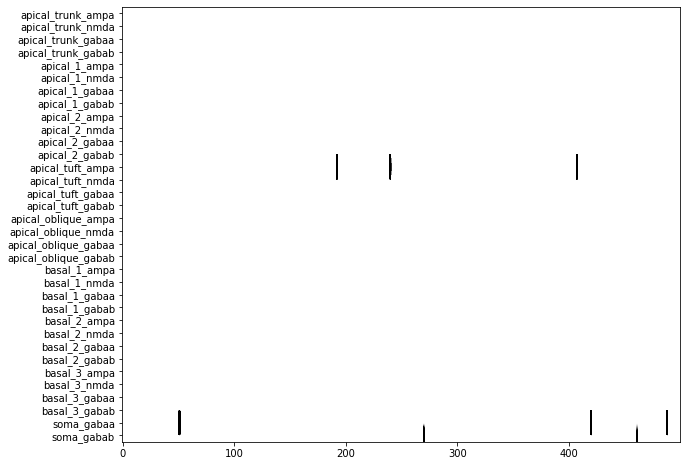

In [34]:
plt.figure(figsize=(10,8))

plt.imshow(validation_set.datasets[4][:][0][0, :, :].detach().cpu().numpy().T, aspect='auto', cmap='gray_r', vmin=0, vmax=0.0001)
_ = plt.yticks(ticks=list(range(len(isec_names))), labels=isec_names)

In [35]:
# test_pred = utils.evaluate_model(model, validation_generator, device)
# test_pred = test_pred.squeeze()

In [36]:
def run_model(model, validation_set):
    val_data = validation_set[:][0][:,:,:].float().to(device)
    with torch.no_grad():
        model.eval()
        output_sequence = []
        hidden = model.init_hidden(val_data.size(0))
        for t in range(model.kernel_size, val_data.size(1)):
            output, hidden = model(val_data[:,(t-model.kernel_size):t, :], hidden)
            output_sequence.append(output)

        output_sequence = torch.cat(output_sequence, dim=1)

    return output_sequence


In [55]:
val_idx = 8
test_pred = run_model(model, validation_set.datasets[val_idx])


val_plot_data = np.concatenate(validation_set.datasets[val_idx][:][1][:,model.kernel_size:,:].detach().cpu().numpy(), axis=0)
test_plot_data = np.concatenate(test_pred.detach().cpu().numpy(), axis=0)

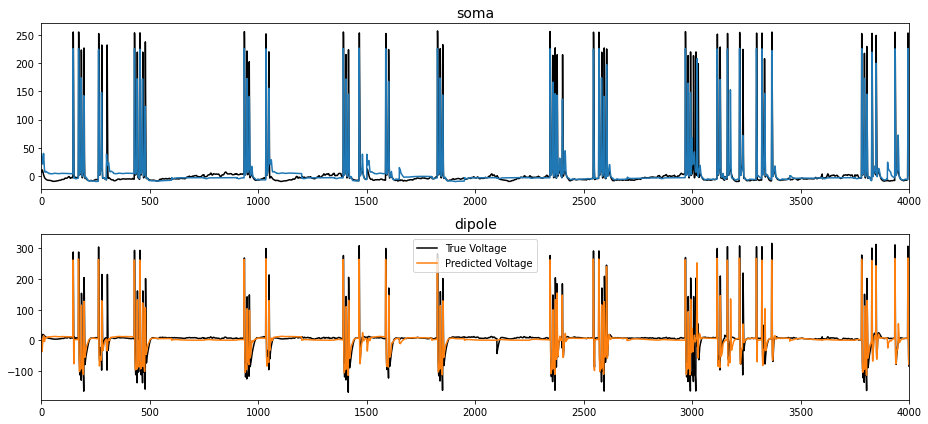

In [56]:
dt = 0.5
plt.figure(figsize=(13,3 * output_size))
tvec = np.linspace(0, val_plot_data.shape[0] * dt, val_plot_data.shape[0])
for idx in range(output_size):
    plt.subplot(output_size, 1, idx+1)
    plt.plot(tvec, val_plot_data[:,idx], color='k', label='True Voltage')
    # plt.plot(test_pred, color=f'C{idx}', label='Predicted Voltage')
    plt.plot(tvec, test_plot_data[:,idx], color=f'C{idx}', label='Predicted Voltage')
    plt.xlim(0,4000)
    plt.title(vsec_names[idx], fontsize=14)
    # plt.ylim(-0.5,1.8)
plt.legend()
plt.tight_layout()